In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.distributions.normal import Normal

**HelperFunction**

In [2]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28), nrow=5, show=True):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    if show:
        plt.show()

def get_noise(n_samples, input_dim, device='cpu'):
    return torch.randn(n_samples, input_dim, device=device)

def combine_vectors(x,y):
    return torch.cat([x.float(),y.float()],1)

**Generator**

In [3]:
def make_gen_block(input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
    if not final_layer:
        return nn.Sequential(
            nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=True),
        )
    else:
        return nn.Sequential(
            nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
            nn.Tanh(),
        )

class Generator(nn.Module):
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            make_gen_block(z_dim, hidden_dim * 4),
            make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            make_gen_block(hidden_dim * 2, hidden_dim),
            make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def forward(self, noise):
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)

**Discriminator**

In [4]:
def make_disc_block(input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
    if not final_layer:
        return nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            nn.BatchNorm2d(output_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )
    else:
        return nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size, stride),
        )

class Discriminator(nn.Module):
    def __init__(self, im_chan=1, hidden_dim=64, c_dim=10):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            make_disc_block(im_chan, hidden_dim),
            make_disc_block(hidden_dim, hidden_dim * 2),
        )
        self.d_layer = make_disc_block(hidden_dim * 2, 1, final_layer=True)
        self.q_layer = nn.Sequential(
            make_disc_block(hidden_dim * 2, hidden_dim * 2),
            make_disc_block(hidden_dim * 2, 2 * c_dim, kernel_size=1, final_layer=True)
        )

    def forward(self, image):
        intermediate_pred = self.disc(image)
        disc_pred = self.d_layer(intermediate_pred)
        q_pred = self.q_layer(intermediate_pred)
        return disc_pred.view(len(disc_pred), -1), q_pred.view(len(q_pred), -1)

**Initialize Component**

In [5]:
adv_criterion = nn.BCEWithLogitsLoss()
c_criterion = lambda c_true, mean, logvar: Normal(mean, logvar.exp()).log_prob(c_true).mean()
c_lambda = 0.1
mnist_shape = (1, 28, 28)
n_epochs = 80
z_dim = 64
c_dim = 2
display_step = 500
batch_size = 128

# InfoGAN uses two different learning rates for the models
d_lr = 2e-4
g_lr = 1e-3
device = 'cuda'

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

In [8]:
gen = Generator(z_dim + c_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=g_lr)
disc = Discriminator(im_chan=mnist_shape[0], c_dim=c_dim).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=d_lr)

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

**Training Process**

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1, step 500: Generator loss: 0.7720265357494355, discriminator loss: 0.7594241868257523


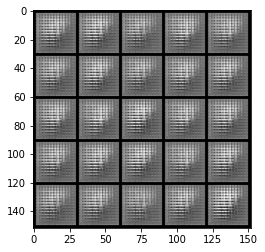

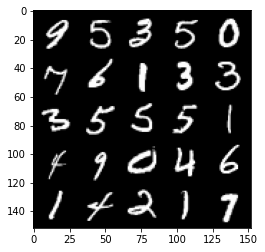

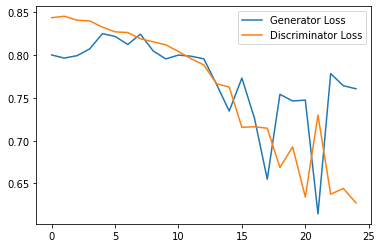

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2, step 1000: Generator loss: 1.31785103225708, discriminator loss: 0.36127975237369536


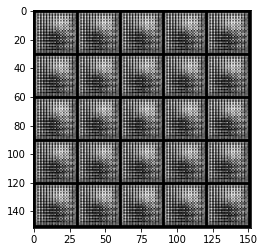

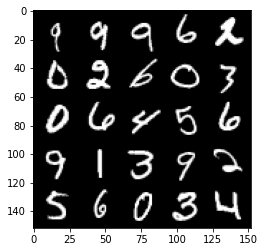

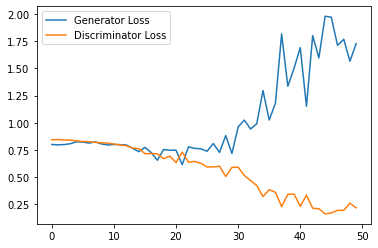

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3, step 1500: Generator loss: 2.6194753012657164, discriminator loss: 0.10120458040386439


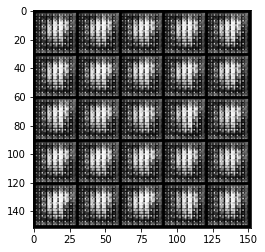

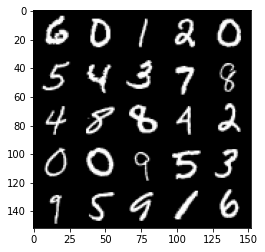

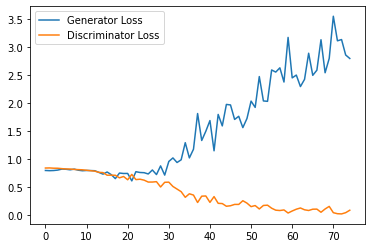

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4, step 2000: Generator loss: 3.18545304274559, discriminator loss: 0.08697419285215438


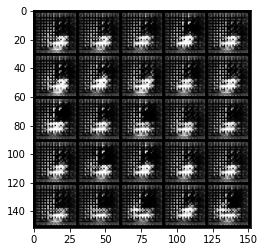

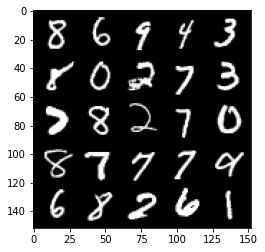

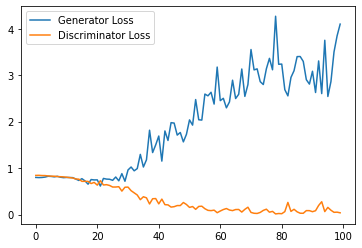

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5, step 2500: Generator loss: 2.5161171503067017, discriminator loss: 0.24439432598650457


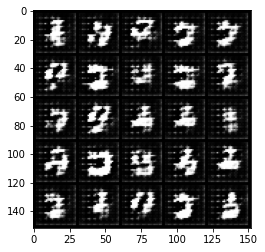

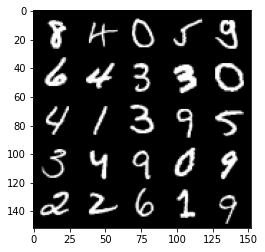

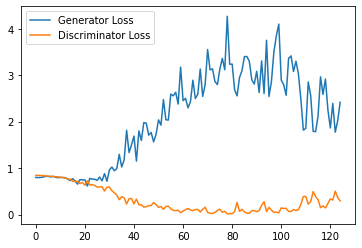

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6, step 3000: Generator loss: 2.2284361448287964, discriminator loss: 0.28571522277593614


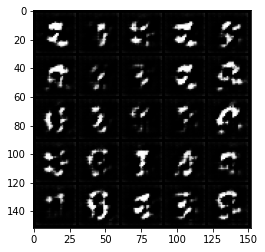

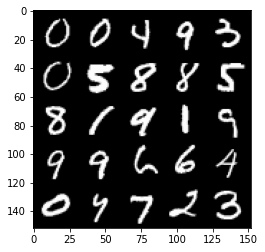

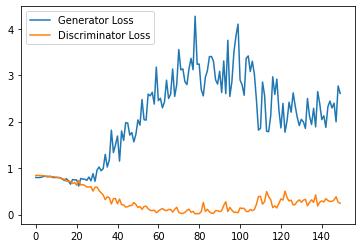

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7, step 3500: Generator loss: 2.219419217824936, discriminator loss: 0.29820021605491637


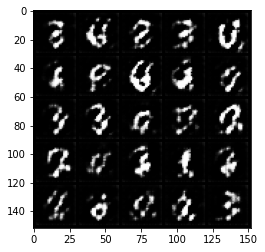

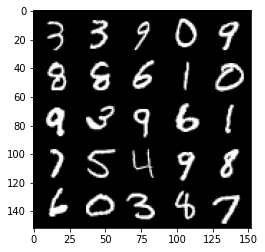

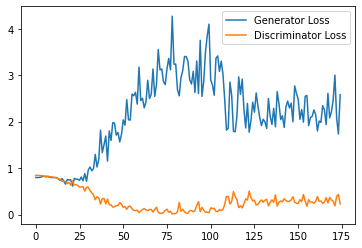

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8, step 4000: Generator loss: 2.094949726819992, discriminator loss: 0.3820060248076916


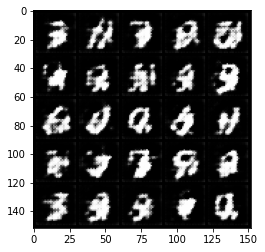

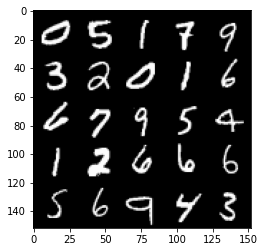

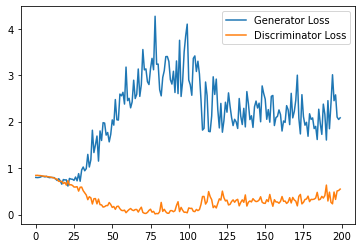

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9, step 4500: Generator loss: 1.8644440159797668, discriminator loss: 0.3474724377095699


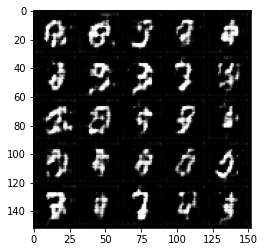

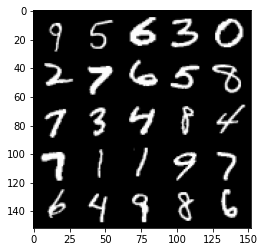

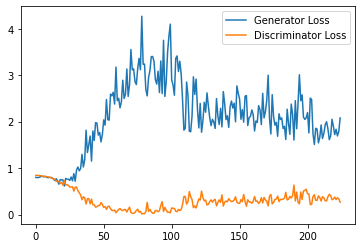

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10, step 5000: Generator loss: 1.9381463545560838, discriminator loss: 0.3552191073298454


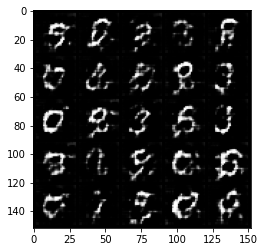

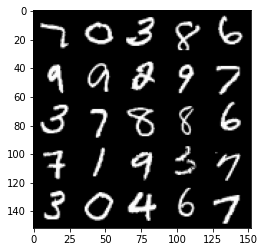

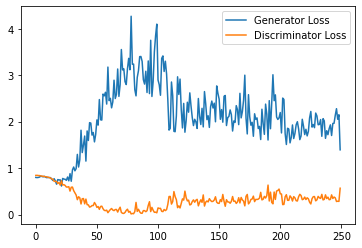

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 11, step 5500: Generator loss: 1.8834703305959701, discriminator loss: 0.36256177416443824


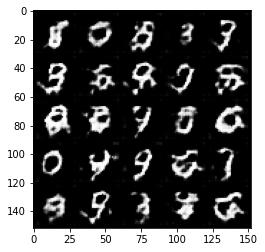

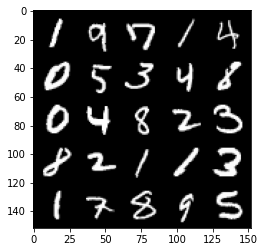

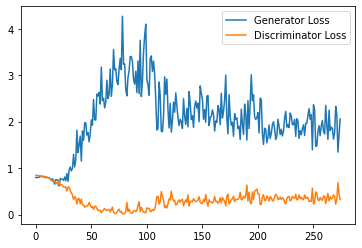

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 12, step 6000: Generator loss: 1.8680509756803512, discriminator loss: 0.4135671975314617


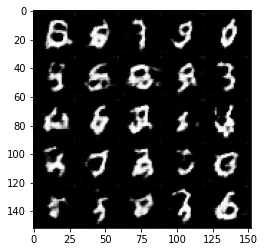

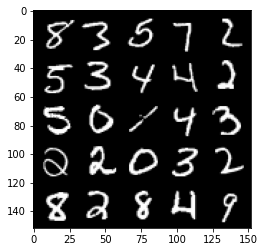

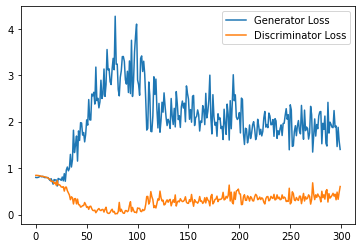

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 13, step 6500: Generator loss: 1.6134519855976104, discriminator loss: 0.42252169173955917


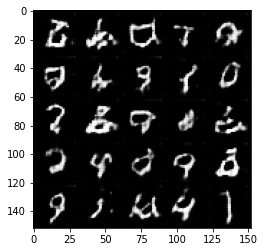

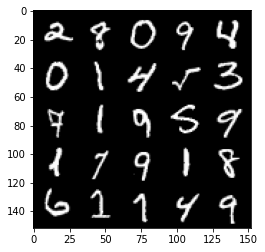

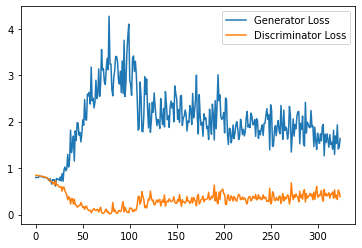

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 14, step 7000: Generator loss: 1.6194005306959152, discriminator loss: 0.4344835548400879


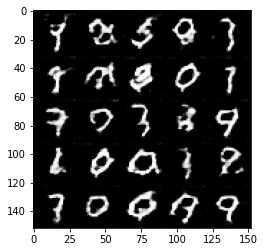

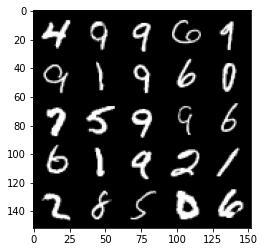

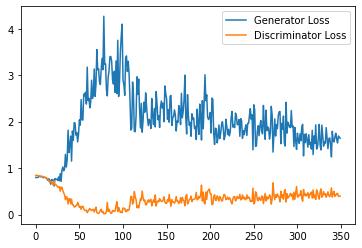

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 15, step 7500: Generator loss: 1.5570635966062545, discriminator loss: 0.4531241528689861


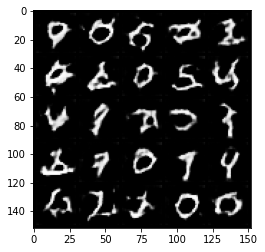

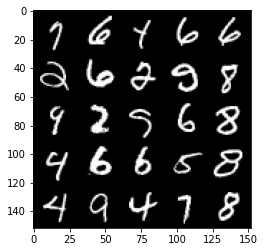

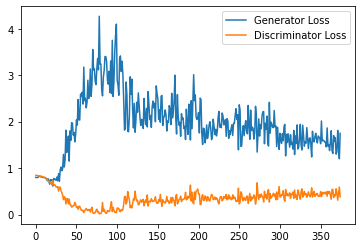

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 17, step 8000: Generator loss: 1.5320339577198028, discriminator loss: 0.4803158265054226


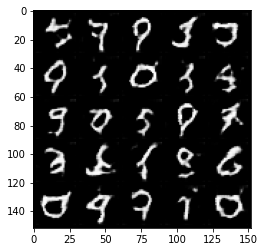

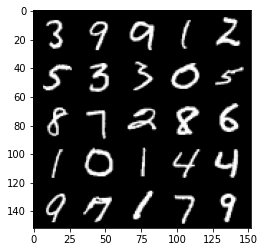

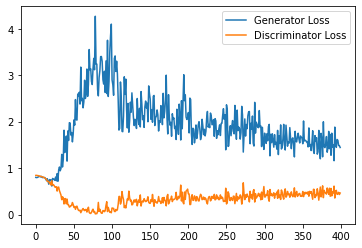

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 18, step 8500: Generator loss: 1.4400464853048325, discriminator loss: 0.49550087854266167


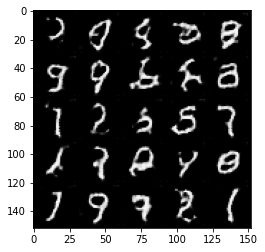

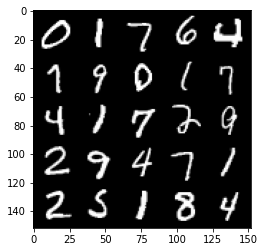

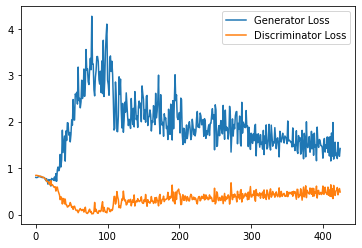

KeyboardInterrupt: ignored

In [9]:
cur_step = 0
generator_losses = []
discriminator_losses = []

for epoch in range(n_epochs):
    for real,_ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        c_labels = get_noise(cur_batch_size,c_dim,device=device)
        
        #================DISCRIMINATOR================
        disc_opt.zero_grad()

        fake_noise = get_noise(cur_batch_size,z_dim,device=device)
        noise_and_labels = combine_vectors(fake_noise,c_labels)
        fake = gen(noise_and_labels)

        disc_fake_pred, disc_q_pred = disc(fake.detach())
        disc_q_mean = disc_q_pred[:, :c_dim]
        disc_q_logvar = disc_q_pred[:, c_dim:]
        mutual_information = c_criterion(c_labels, disc_q_mean, disc_q_logvar)
        disc_real_pred, _ = disc(real)

        disc_fake_loss = adv_criterion(disc_fake_pred,torch.zeros_like(disc_fake_pred))
        disc_real_loss = adv_criterion(disc_real_pred,torch.ones_like(disc_real_pred))

        disc_loss = (disc_fake_loss + disc_real_loss) / 2 - c_lambda * mutual_information
        disc_loss.backward(retain_graph=True)

        disc_opt.step() 
        #================DISCRIMINATOR================

        discriminator_losses += [disc_loss.item()]

        #================GENERATOR=================
        gen_opt.zero_grad()

        gen_fake_pred, gen_q_pred = disc(fake)
        gen_q_mean = gen_q_pred[:, :c_dim]
        gen_q_logvar = gen_q_pred[:, c_dim:]
        mutual_information = c_criterion(c_labels, gen_q_mean, gen_q_logvar)

        gen_fake_loss = adv_criterion(gen_fake_pred,torch.ones_like(gen_fake_pred))
        gen_loss = gen_fake_loss - c_lambda * mutual_information
        gen_loss.backward()

        gen_opt.step()
        #================GENERATOR=================

        generator_losses += [gen_loss.item()]
        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            disc_mean = sum(discriminator_losses[-display_step:]) / display_step
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {gen_mean}, discriminator loss: {disc_mean}")
            show_tensor_images(fake)
            show_tensor_images(real)
            step_bins = 20
            x_axis = sorted([i * step_bins for i in range(len(generator_losses) // step_bins)] * step_bins)
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(discriminator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Discriminator Loss"
            )
            plt.legend()
            plt.show()
        cur_step += 1

**Check interpolation**

In [10]:
gen = gen.eval()

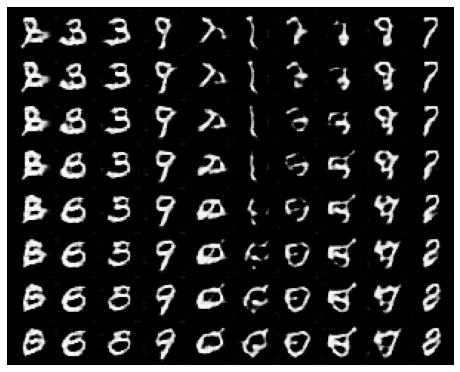

In [16]:
import math

### Change me! ###
n_interpolation = 8 # Choose the interpolation: how many intermediate images you want + 2 (for the start and end image)

def interpolate_class(n_view=10):
    interpolation_noise = get_noise(n_view, z_dim, device=device).repeat(n_interpolation, 1)
    first_label = get_noise(1, c_dim).repeat(n_view, 1)[None, :]
    second_label = first_label.clone()
    first_label[:, :, 0] =  -2
    second_label[:, :, 0] =  2
    

    # Calculate the interpolation vector between the two labels
    percent_second_label = torch.linspace(0, 1, n_interpolation)[:, None, None]
    interpolation_labels = first_label * (1 - percent_second_label) + second_label * percent_second_label
    interpolation_labels = interpolation_labels.view(-1, c_dim)

    # Combine the noise and the labels
    noise_and_labels = combine_vectors(interpolation_noise, interpolation_labels.to(device))
    fake = gen(noise_and_labels)
    show_tensor_images(fake, num_images=n_interpolation * n_view, nrow=n_view, show=False)

plt.figure(figsize=(8, 8))
interpolate_class()
_ = plt.axis('off')


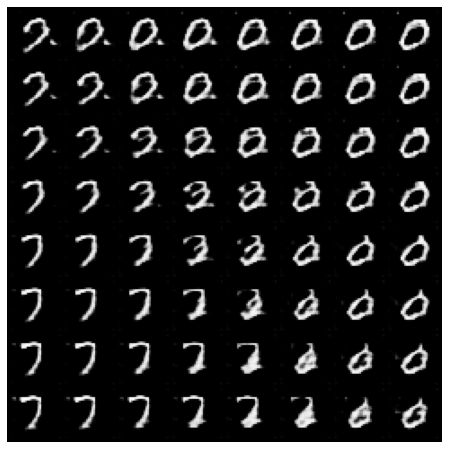

In [17]:
import math

### Change me! ###
n_interpolation = 8 # Choose the interpolation: how many intermediate images you want + 2 (for the start and end image)

def interpolate_class():
    interpolation_noise = get_noise(1, z_dim, device=device).repeat(n_interpolation * n_interpolation, 1)
    first_label = get_noise(1, c_dim).repeat(n_interpolation * n_interpolation, 1)
    
    # Calculate the interpolation vector between the two labels
    first_label = torch.linspace(-2, 2, n_interpolation).repeat(n_interpolation)
    second_label = torch.linspace(-2, 2, n_interpolation).repeat_interleave(n_interpolation)
    interpolation_labels = torch.stack([first_label, second_label], dim=1) 

    # Combine the noise and the labels
    noise_and_labels = combine_vectors(interpolation_noise, interpolation_labels.to(device))
    fake = gen(noise_and_labels)
    show_tensor_images(fake, num_images=n_interpolation * n_interpolation, nrow=n_interpolation, show=False)

plt.figure(figsize=(8, 8))
interpolate_class()
_ = plt.axis('off')
